In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score


In [2]:
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
quali = pd.read_csv('qualifying.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
circuit = pd.read_csv('circuits.csv')
status = pd.read_csv('status.csv')

In [3]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])


/var/folders/z0/vk3_b5f919531l_8d46zglcc0000gn/T/ipykernel_14183/3343539075.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])


In [4]:
#drop the columns which are not important
data = df5.drop(columns=['round','circuitId','time_x','url_x','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','resultId','fastestLap','q2','q3','milliseconds','q1', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'])


In [5]:
data

,raceId,year,date,grid,statusId,position_y,forename,surname,dob,nationality_x,name_y,nationality_y,name,country
0,1,2009,2009-03-29,1,1,1,Jenson,Button,1980-01-19,British,Brawn,British,Albert Park Grand Prix Circuit,Australia
1,1,2009,2009-03-29,2,1,2,Rubens,Barrichello,1972-05-23,Brazilian,Brawn,British,Albert Park Grand Prix Circuit,Australia
2,18,2008,2008-03-16,12,4,13,Jenson,Button,1980-01-19,British,Honda,Japanese,Albert Park Grand Prix Circuit,Australia
3,36,2007,2007-03-18,14,11,14,Jenson,Button,1980-01-19,British,Honda,Japanese,Albert Park Grand Prix Circuit,Australia
4,55,2006,2006-04-02,1,11,1,Jenson,Button,1980-01-19,British,Honda,Japanese,Albert Park Grand Prix Circuit,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,1051,2021,2021-11-21,18,11,18,Antonio,Giovinazzi,1993-12-14,Italian,Alfa Romeo,Swiss,Losail International Circuit,Qatar
9801,1051,2021,2021-11-21,19,11,19,Mick,Schumacher,1999-03-22,German,Haas F1 Team,American,Losail International Circuit,Qatar
9802,1051,2021,2021-11-21,20,12,20,Nikita,Mazepin,1999-03-02,Russian,Haas F1 Team,American,Losail International Circuit,Qatar
9803,1051,2021,2021-11-21,2,11,4,Pierre,Gasly,1996-02-07,French,AlphaTauri,Italian,Losail International Circuit,Qatar


In [6]:
#since regulations change, we will only be predicting using recent data
data = data[data['year']>=1980]
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

data['age'] = (data['date'] - data['dob']).dt.days // 365

In [7]:
#updating constructors to match current titles
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine' if x=='Renault' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [8]:
#Feature Engineering: adjusting vars to create features determining whether a driver is at their home race


data['driver_nationality'] = data['driver_nationality'].str[:3]
data['constructor_nationality'] = data['constructor_nationality'].str[:3]

country_mapping = {'UK': 'Bri', 'USA': 'Ame', 'Fra': 'Fre'}
data['country'] = data['country'].replace(country_mapping).str[:3]

data['driver_home'] = data.apply(lambda row: 1 if row['driver_nationality'][:3] == row['country'] else 0, axis=1)
data['constructor_home'] = data.apply(lambda row: 1 if row['constructor_nationality'][:3] == row['country'] else 0, axis=1)

data[['driver_home', 'constructor_home']] = data[['driver_home', 'constructor_home']].astype(int)

In [9]:
status

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
...,...,...
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray


In [10]:
#reasons for DNF(did not finish)
#these statuses result in DNF per F1 regulations
dnf_statuses = set([3, 4, 20, 29, 31, 41, 68, 73, 81, 97, 82, 104, 107, 130, 137])

#the list is dnf because of a driver
data['driver_dnf'] = data['statusId'].isin(dnf_statuses).astype(int)

#everything except the list and 1 (finished) is dnf do to constructor error
data['constructor_dnf'] = data['statusId'].apply(lambda x: int(x not in dnf_statuses))

data.drop(['forename', 'surname'], axis=1, inplace=True)

/var/folders/z0/vk3_b5f919531l_8d46zglcc0000gn/T/ipykernel_14183/3469163409.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dnf_by_driver = data.groupby('driver').sum()['driver_dnf']


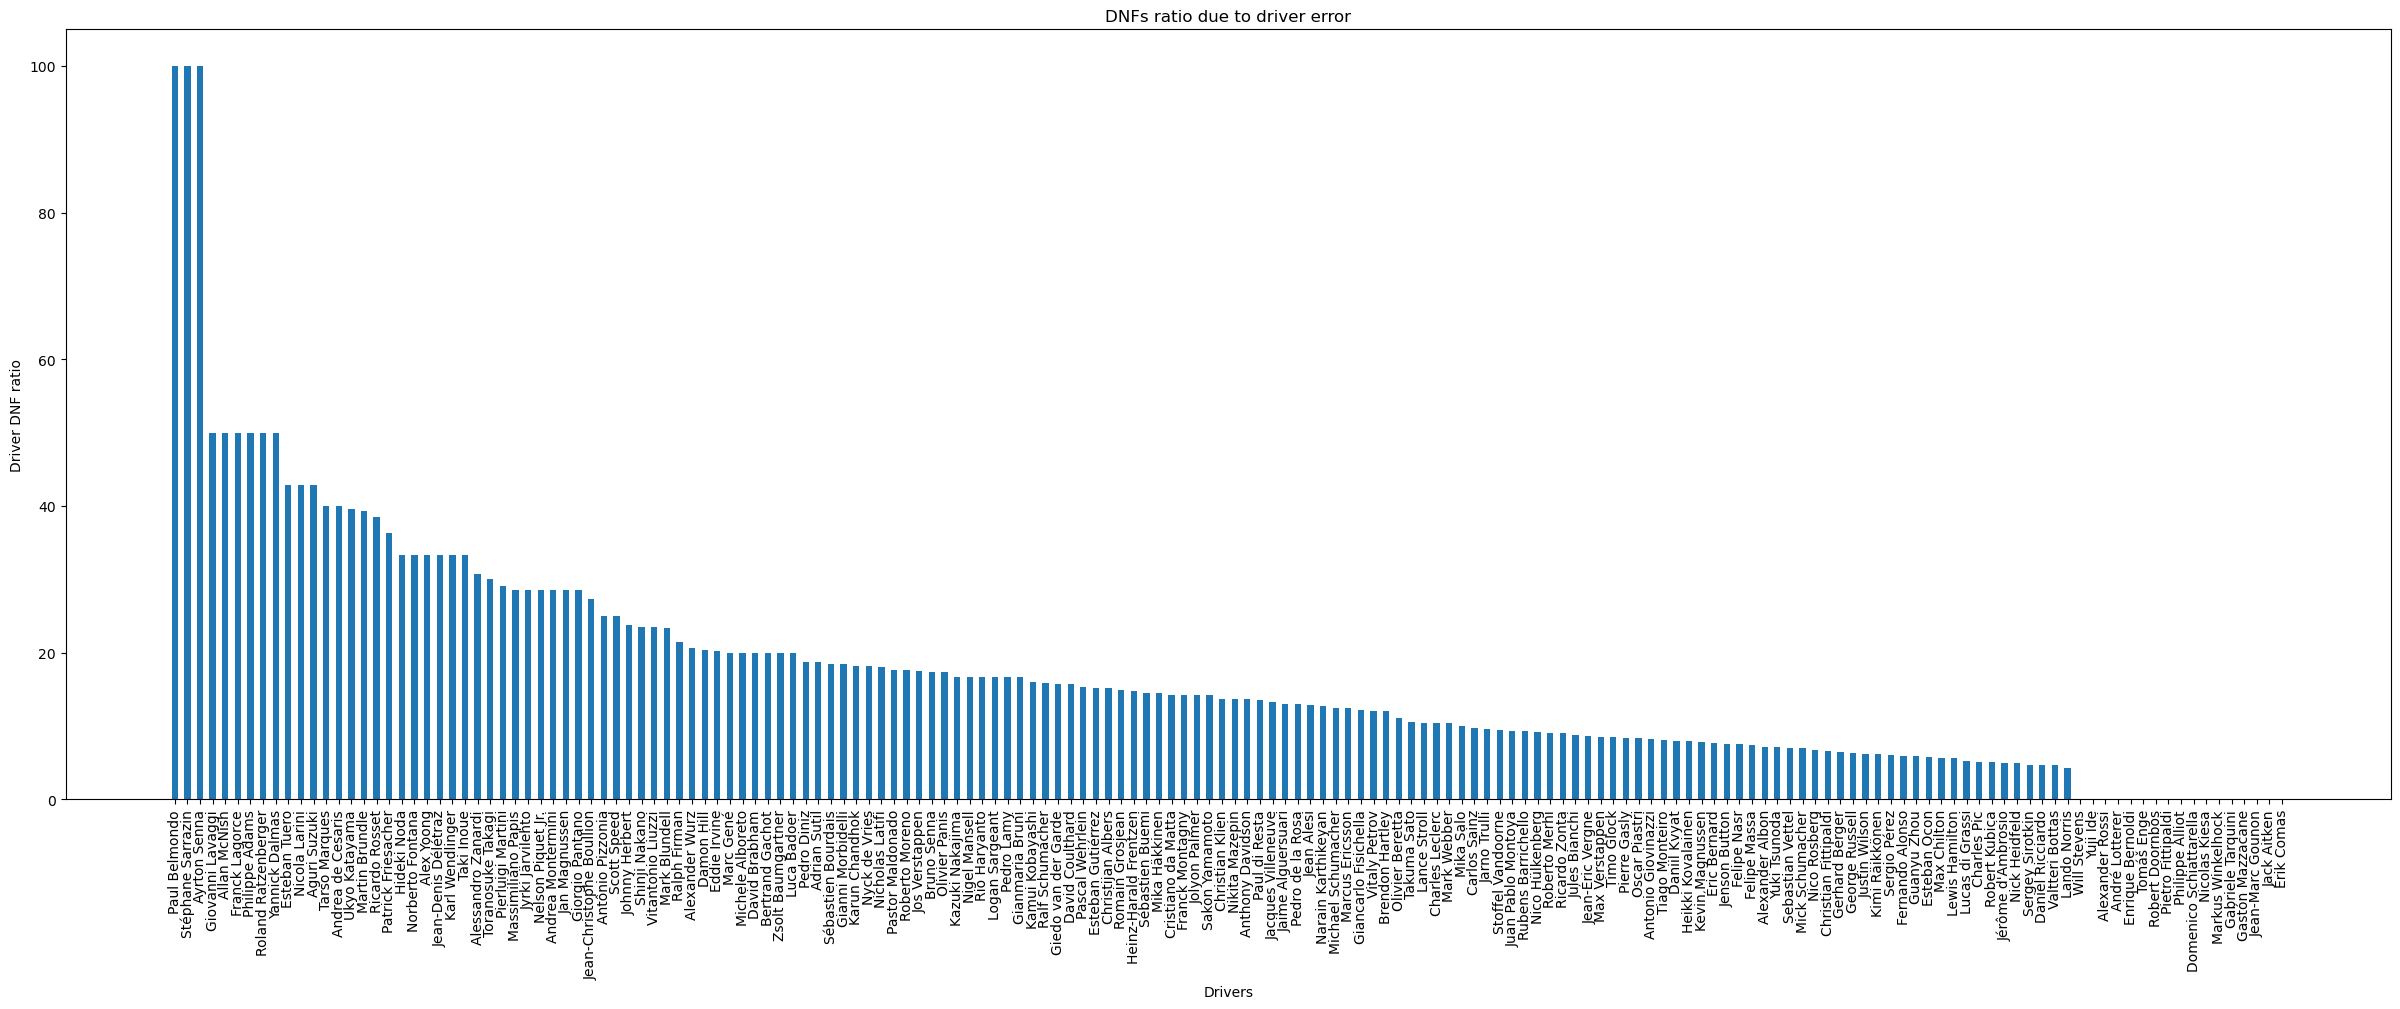

In [11]:
#dnfs per driver
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
for bar in bars.patches:
    yval = bar.get_height()
plt.show()

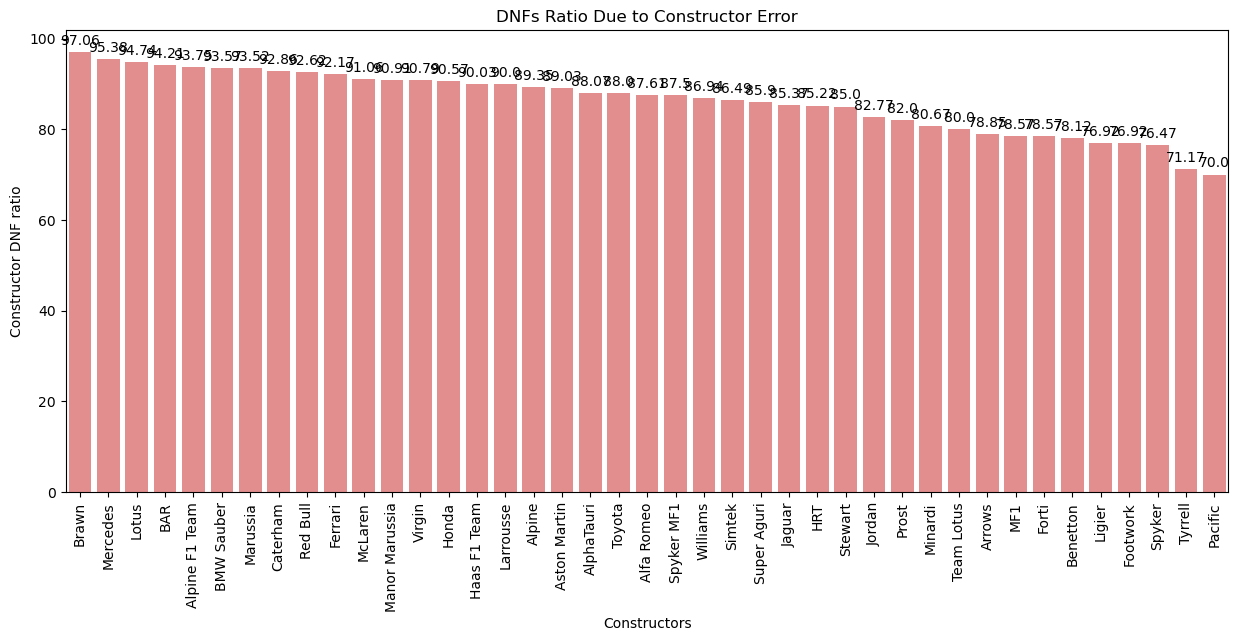

In [12]:
# Calculate DNF ratio by constructor
constructor_dnf_ratio = (
    (data.groupby('constructor')['constructor_dnf'].sum() * 100 / data.groupby('constructor').size())
    .sort_values(ascending=False)
)

# Plotting using seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x=constructor_dnf_ratio.index, y=constructor_dnf_ratio, color='lightcoral')
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs Ratio Due to Constructor Error')

# Display DNF ratios on top of bars
for i, value in enumerate(constructor_dnf_ratio):
    plt.text(i, value + 1, f'{round(value, 2)}', ha='center', va='bottom')

plt.show()

In [13]:
print(constructor_dnf_ratio)

constructor
Brawn             97.058824
Mercedes          95.378928
Lotus             94.736842
BAR               94.214876
Alpine F1 Team    93.750000
BMW Sauber        93.571429
Marussia          93.518519
Caterham          92.857143
Red Bull          92.618384
Ferrari           92.173913
McLaren           91.057797
Manor Marussia    90.909091
Virgin            90.789474
Honda             90.566038
Haas F1 Team      90.032154
Larrousse         90.000000
Alpine            89.349112
Aston Martin      89.034370
AlphaTauri        88.070692
Toyota            88.000000
Alfa Romeo        87.612903
Spyker MF1        87.500000
Williams          86.942329
Simtek            86.486486
Super Aguri       85.897436
Jaguar            85.365854
HRT               85.217391
Stewart           85.000000
Jordan            82.773109
Prost             82.000000
Minardi           80.672269
Team Lotus        80.000000
Arrows            78.846154
MF1               78.571429
Forti             78.571429
Benetton

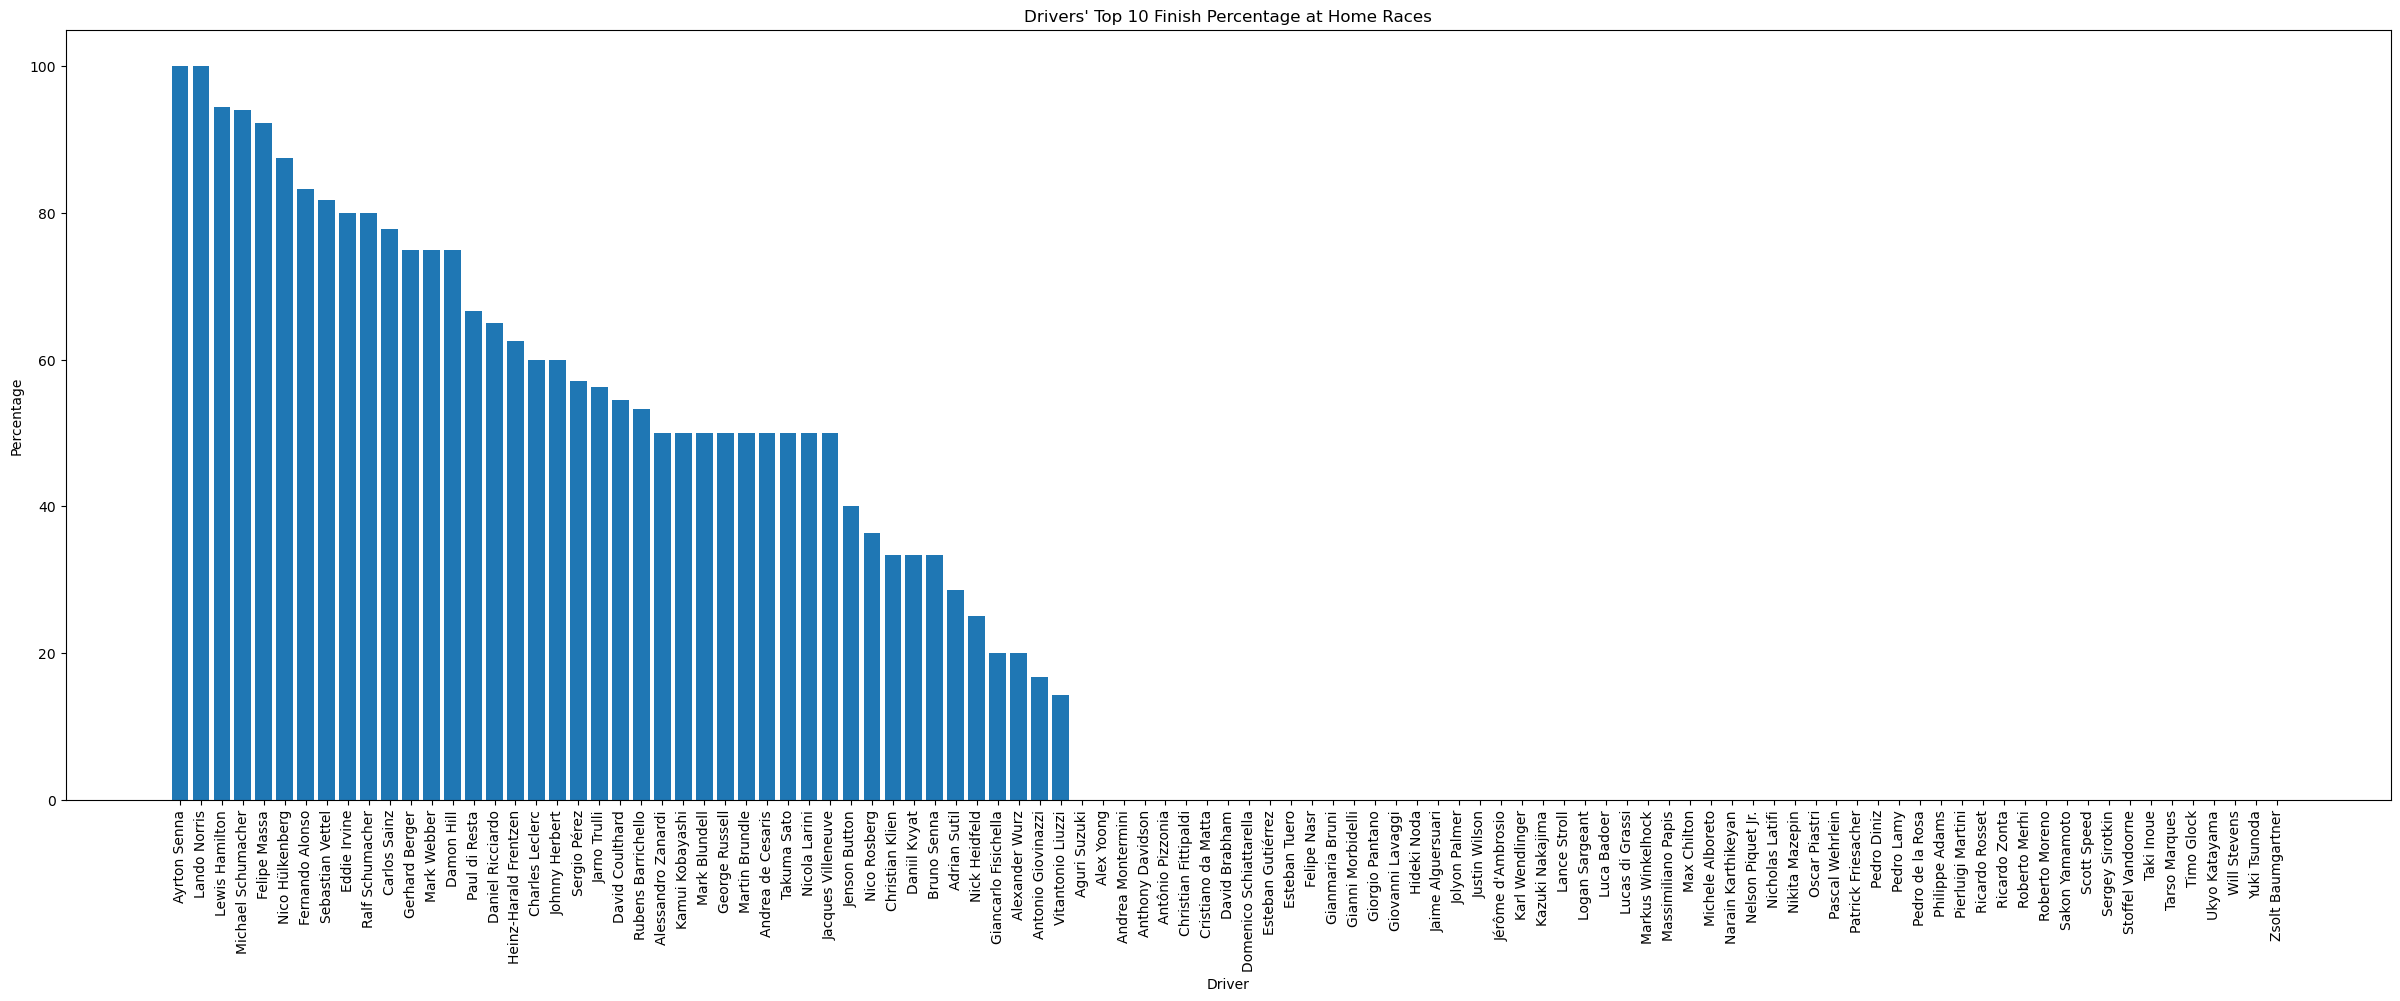

In [14]:
#The top 10 positions get points towards the championship
driver_home_top10 = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home'] == 1].groupby('driver').sum(numeric_only=True)['driver_home']
driver_home_top10_ratio = (driver_home_top10*100/total_home_races).sort_values(ascending=False).fillna(0)
# Plotting
plt.figure(figsize=(30, 10))
bars = plt.bar(x=driver_home_top10_ratio.index, height=driver_home_top10_ratio, align='center', width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('Percentage')
plt.title('Drivers\' Top 10 Finish Percentage at Home Races')


plt.show()

In [15]:
# Average percent of finish statuses for driver
driver_dnf_ratio = data.groupby('driver')['driver_dnf'].mean()
driver_finished = 1 - driver_dnf_ratio
driver_finished_dict = driver_finished.to_dict()

data['driver_finished'] = data['driver'].map(driver_finished_dict)

In [16]:
# Calculate constructor finished ratio and create a dictionary
constructor_finished = 1 - data.groupby('constructor')['constructor_dnf'].mean()
constructor_finished_dict = constructor_finished.to_dict()

data['constructor_finished'] = data['constructor'].map(constructor_finished_dict)

# EDA

In [17]:
import folium
from folium import plugins

# Create a map centered around the mean latitude and longitude of the circuits
map_center = [circuit['lat'].mean(), circuit['lng'].mean()]
map_circuits = folium.Map(location=map_center, zoom_start=3)

# Add markers for each circuit
for index, row in circuit.iterrows():
    folium.Marker([row['lat'], row['lng']], popup=row['name']).add_to(map_circuits)

# Display the map
map_circuits.save('circuits_map.html')  # Save the map to an HTML file
map_circuits

In [18]:
data['driver'].unique()

array(['Jenson Button', 'Rubens Barrichello', 'Takuma Sato',
       'Jacques Villeneuve', 'Ricardo Zonta', 'Jarno Trulli',
       'Fernando Alonso', 'Nick Heidfeld', 'Giancarlo Fisichella',
       'Robert Kubica', 'Nelson Piquet Jr.', 'Heikki Kovalainen',
       'Nico Hülkenberg', 'Vitaly Petrov', 'Daniel Ricciardo',
       'Kevin Magnussen', 'Carlos Sainz', 'Jolyon Palmer',
       'Alexander Wurz', 'Jean Alesi', 'Gerhard Berger', 'Nico Rosberg',
       'Mark Webber', 'Felipe Massa', 'Kazuki Nakajima',
       'Ralf Schumacher', 'Juan Pablo Montoya', 'Heinz-Harald Frentzen',
       'Alessandro Zanardi', 'Damon Hill', 'Bruno Senna',
       'Pastor Maldonado', 'Valtteri Bottas', 'Lance Stroll',
       'Sergey Sirotkin', 'Alexander Albon', 'George Russell',
       'Nicholas Latifi', 'Logan Sargeant', 'Kimi Räikkönen',
       'Lewis Hamilton', 'David Coulthard', 'Mika Häkkinen',
       'Sergio Pérez', 'Stoffel Vandoorne', 'Lando Norris',
       'Oscar Piastri', 'Sebastian Vettel', 'Michael 

In [19]:
#removing retired drivers and constructors as of 2023 season
active_constructors = ['Alpine', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Logan Sargeant', 'Oscar Piastri',
                  'Charles Leclerc', 'Lewis Hamilton', 'Guanyu Zhou',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Nico Hülkenberg',
                  'Fernando Alonso','Yuki Tsunoda', 'Nyck de Vries']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [20]:
data

,raceId,year,date,quali_pos,statusId,position,dob,driver_nationality,constructor,constructor_nationality,...,driver,age,driver_home,constructor_home,driver_dnf,constructor_dnf,driver_finished,constructor_finished,active_driver,active_constructor
0,1,2009,2009-03-29,1,1,1,1980-01-19,Bri,Brawn,Bri,...,Jenson Button,29,0,0,0,1,0.923954,0.029412,0,0
1,1,2009,2009-03-29,2,1,2,1972-05-23,Bra,Brawn,Bri,...,Rubens Barrichello,36,0,0,0,1,0.907080,0.029412,0,0
2,18,2008,2008-03-16,12,4,13,1980-01-19,Bri,Honda,Jap,...,Jenson Button,28,0,0,1,0,0.923954,0.094340,0,0
3,36,2007,2007-03-18,14,11,14,1980-01-19,Bri,Honda,Jap,...,Jenson Button,27,0,0,0,1,0.923954,0.094340,0,0
4,55,2006,2006-04-02,1,11,1,1980-01-19,Bri,Honda,Jap,...,Jenson Button,26,0,0,0,1,0.923954,0.094340,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,1051,2021,2021-11-21,18,11,18,1993-12-14,Ita,Alfa Romeo,Swi,...,Antonio Giovinazzi,27,0,0,0,1,0.918033,0.123871,0,1
9801,1051,2021,2021-11-21,19,11,19,1999-03-22,Ger,Haas F1 Team,Ame,...,Mick Schumacher,22,0,0,0,1,0.930233,0.099678,0,1
9802,1051,2021,2021-11-21,20,12,20,1999-03-02,Rus,Haas F1 Team,Ame,...,Nikita Mazepin,22,0,0,0,1,0.863636,0.099678,0,1
9803,1051,2021,2021-11-21,2,11,4,1996-02-07,Fre,AlphaTauri,Ita,...,Pierre Gasly,25,0,0,0,1,0.915966,0.119293,1,1


In [21]:
cleaned_data = data[['GP_name','quali_pos', 'age','constructor','driver','position','driver_finished','constructor_finished','active_driver','active_constructor','dob', 'raceId', 'driver_home', 'constructor_home']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data

,GP_name,quali_pos,age,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,raceId,driver_home,constructor_home
20,Albert Park Grand Prix Circuit,10,27,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,1,0,0
21,Albert Park Grand Prix Circuit,11,26,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,18,0,0
22,Albert Park Grand Prix Circuit,3,24,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,55,0,0
23,Albert Park Grand Prix Circuit,13,23,Alpine,Fernando Alonso,13,0.940510,0.106509,1,1,1981-07-29,71,0,0
24,Albert Park Grand Prix Circuit,5,22,Alpine,Fernando Alonso,5,0.940510,0.106509,1,1,1981-07-29,90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,Losail International Circuit,6,32,Mercedes,Valtteri Bottas,3,0.953052,0.046211,1,1,1989-08-28,1051,0,0
9797,Losail International Circuit,11,31,Red Bull,Sergio Pérez,11,0.939516,0.073816,1,1,1990-01-26,1051,0,0
9798,Losail International Circuit,7,24,Red Bull,Max Verstappen,2,0.914286,0.073816,1,1,1997-09-30,1051,0,0
9803,Losail International Circuit,2,25,AlphaTauri,Pierre Gasly,4,0.915966,0.119293,1,1,1996-02-07,1051,0,0


In [22]:
cleaned_data

,GP_name,quali_pos,age,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,raceId,driver_home,constructor_home
20,Albert Park Grand Prix Circuit,10,27,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,1,0,0
21,Albert Park Grand Prix Circuit,11,26,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,18,0,0
22,Albert Park Grand Prix Circuit,3,24,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,55,0,0
23,Albert Park Grand Prix Circuit,13,23,Alpine,Fernando Alonso,13,0.940510,0.106509,1,1,1981-07-29,71,0,0
24,Albert Park Grand Prix Circuit,5,22,Alpine,Fernando Alonso,5,0.940510,0.106509,1,1,1981-07-29,90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,Losail International Circuit,6,32,Mercedes,Valtteri Bottas,3,0.953052,0.046211,1,1,1989-08-28,1051,0,0
9797,Losail International Circuit,11,31,Red Bull,Sergio Pérez,11,0.939516,0.073816,1,1,1990-01-26,1051,0,0
9798,Losail International Circuit,7,24,Red Bull,Max Verstappen,2,0.914286,0.073816,1,1,1997-09-30,1051,0,0
9803,Losail International Circuit,2,25,AlphaTauri,Pierre Gasly,4,0.915966,0.119293,1,1,1996-02-07,1051,0,0


In [23]:
ranking_prob = cleaned_data.copy()
cleaned_data = cleaned_data.drop(['raceId'], axis=1)

# Model without feature engineering

In [24]:
sc = StandardScaler()
le = LabelEncoder()

input_df = cleaned_data.copy()

input_df['GP_name'] = le.fit_transform(input_df['GP_name'])
input_df['constructor'] = le.fit_transform(input_df['constructor'])
input_df['driver'] = le.fit_transform(input_df['driver'])

# Exclude datetime columns
X = input_df.drop(['position', 'active_driver', 'active_constructor', 'dob', 'age', 'driver_finished', 'constructor_finished'], axis=1)
y = input_df['position']

# Standardize the features
X_scaled = sc.fit_transform(X)

In [25]:
X

,GP_name,quali_pos,constructor,driver,driver_home,constructor_home
20,0,10,2,5,0,0
21,0,11,2,5,0,0
22,0,3,2,5,0,0
23,0,13,2,5,0,0
24,0,5,2,5,0,0
...,...,...,...,...,...,...
9796,25,6,7,19,0,0
9797,25,11,8,18,0,0
9798,25,7,8,13,0,0
9803,25,2,1,17,0,0


In [26]:
#cross validation for diffrent models
models = [LogisticRegression(max_iter=10000),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


LogisticRegression : 0.3313167259786477
DecisionTreeClassifier : 0.5404422979156076


/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier : 0.557153024911032


/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


SVC : 0.2558045246568378
GaussianNB : 0.044843670564311135
KNeighborsClassifier : 0.28468098627351296


/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


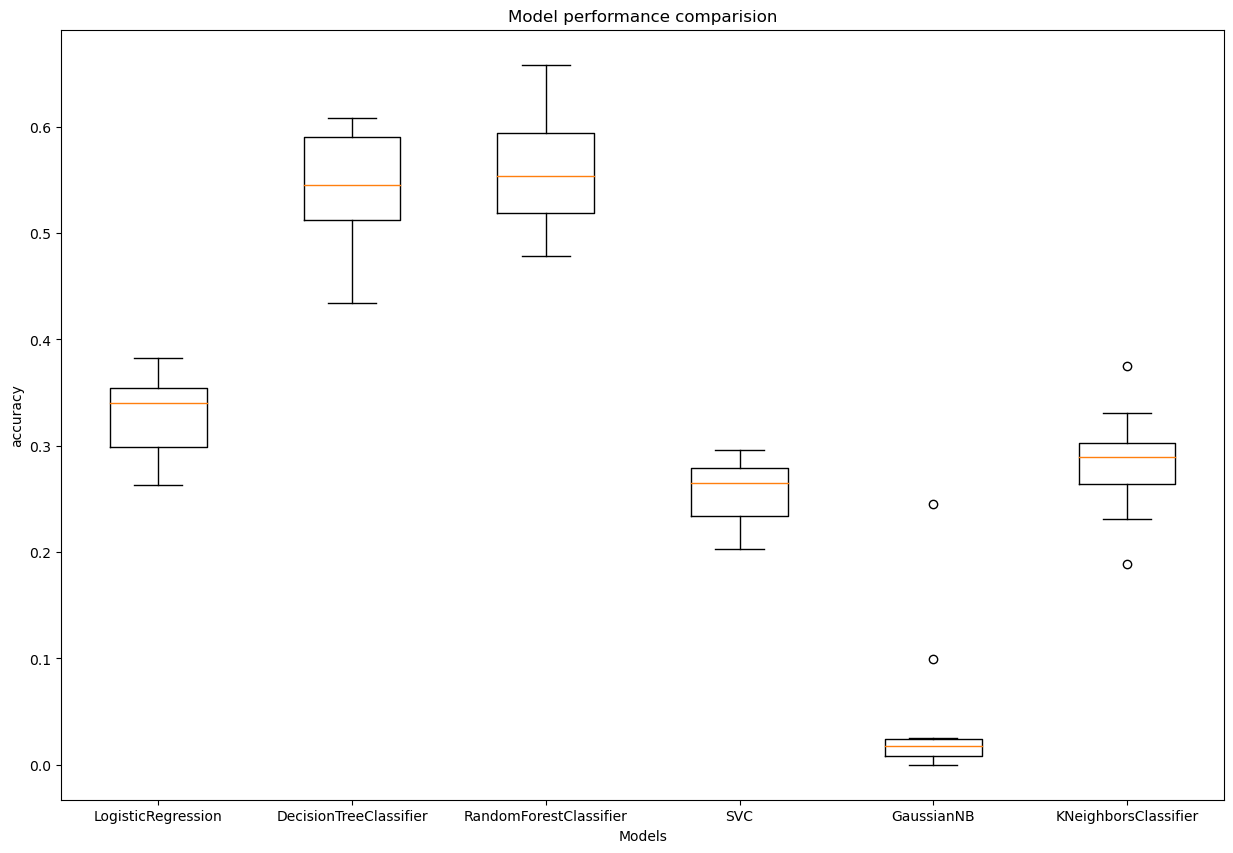

In [27]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

# Models after feature engineering

In [28]:
sc = StandardScaler()
le = LabelEncoder()

input_df = cleaned_data.copy()

input_df['GP_name'] = le.fit_transform(input_df['GP_name'])
input_df['constructor'] = le.fit_transform(input_df['constructor'])
input_df['driver'] = le.fit_transform(input_df['driver'])

# Exclude datetime columns
X = input_df.drop(['position', 'active_driver', 'active_constructor', 'dob'], axis=1)
y = input_df['position']

# Standardize the features
X_scaled = sc.fit_transform(X)

In [29]:
#cross validation for diffrent models
models = [LogisticRegression(max_iter=10000),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


LogisticRegression : 0.33666878495170305
DecisionTreeClassifier : 0.5425788002033554


/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier : 0.5678482460599897


/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


SVC : 0.23228266395526181
GaussianNB : 0.05516903914590747
KNeighborsClassifier : 0.22410015251652263


/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anushaarora/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


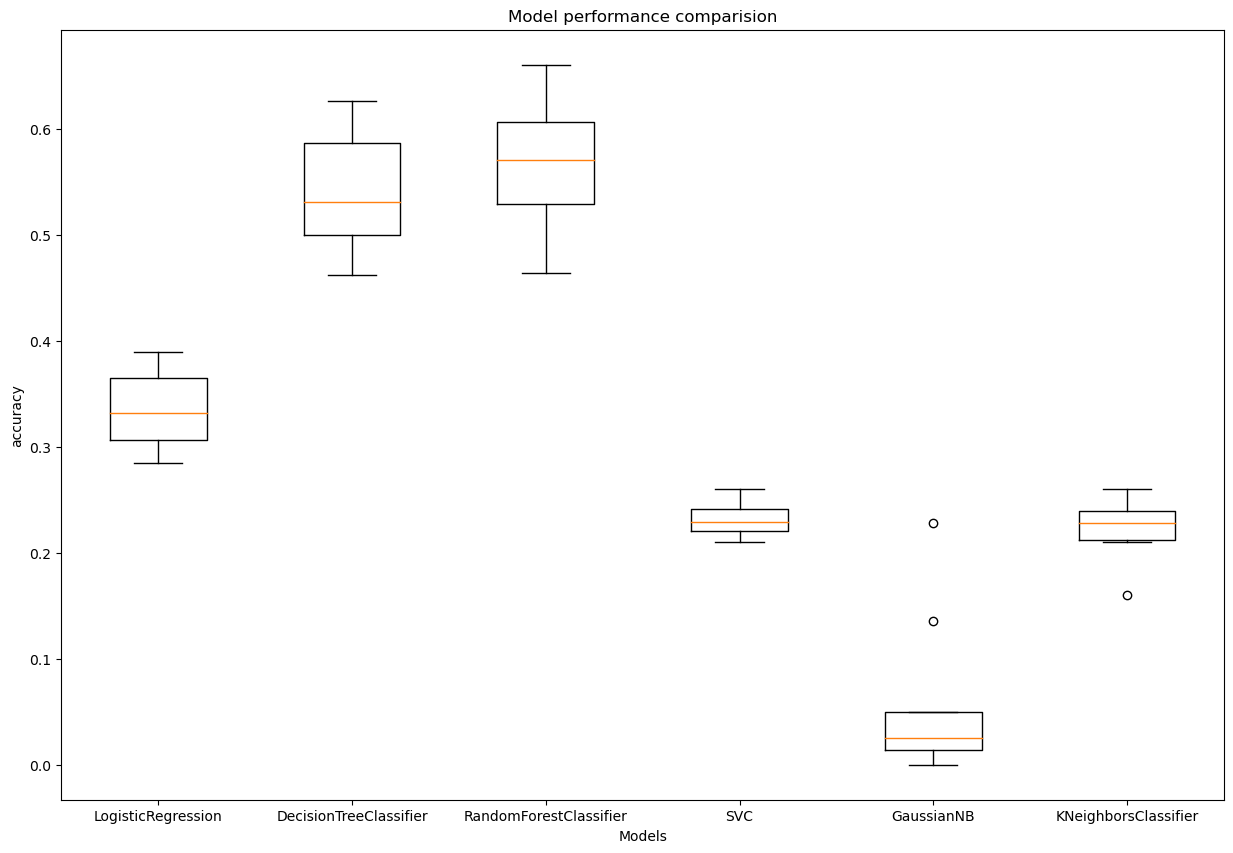

In [30]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

## instead of exact position, let's try to predict chances for a podium/points/no points

In [31]:
#cat 1 for podium finish, 2 for points but no podium, 3 for no points or podium
def group_positions(x):
    return 1 if x < 4 else (3 if x > 10 else 2)

In [32]:
sc = StandardScaler()
le = LabelEncoder()

x = cleaned_data.copy()

x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])

# Exclude datetime columns
X = x.drop(['position', 'active_driver', 'active_constructor', 'dob'], axis=1)
y = x['position'].apply(lambda x: group_positions(x))


# Standardize the features
X_scaled = sc.fit_transform(X)

In [33]:
#cross validation for diffrent models
models = [LogisticRegression(max_iter=10000),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

LogisticRegression : 0.9098589222165734
DecisionTreeClassifier : 0.8942031011692932
RandomForestClassifier : 0.9298284189120489
SVC : 0.9155579562785968
GaussianNB : 0.792982968988307
KNeighborsClassifier : 0.8585688866293848


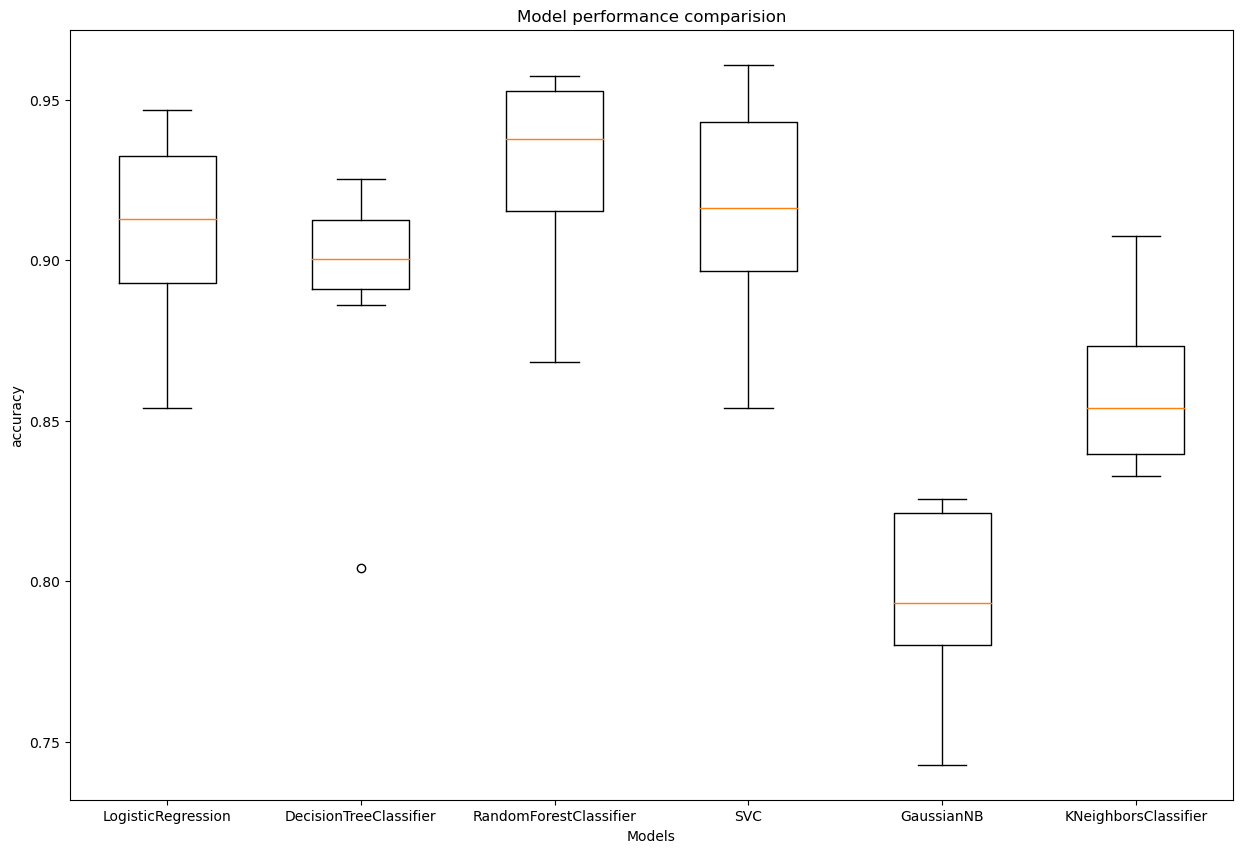

In [34]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

# testing on larger data set (not just active driver)

In [35]:
sc = StandardScaler()
le = LabelEncoder()
lg_data = data[['GP_name','quali_pos','constructor','driver','position','driver_finished','constructor_finished','active_driver','active_constructor','dob', 'driver_home', 'constructor_home']]

x = lg_data.copy()

x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])

# Exclude datetime columns
X = x.drop(['position', 'active_driver', 'active_constructor', 'dob'], axis=1)
y = x['position'].apply(lambda x: group_positions(x))


# Standardize the features
X_scaled = sc.fit_transform(X)

In [36]:
x

,GP_name,quali_pos,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,driver_home,constructor_home
0,1,1,9,65,1,0.923954,0.029412,0,0,1980-01-19,0,0
1,1,2,9,139,2,0.907080,0.029412,0,0,1972-05-23,0,0
2,1,12,16,65,13,0.923954,0.094340,0,0,1980-01-19,0,0
3,1,14,16,65,14,0.923954,0.094340,0,0,1980-01-19,0,0
4,1,1,16,65,1,0.923954,0.094340,0,0,1980-01-19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9800,29,18,0,12,18,0.918033,0.123871,0,1,1993-12-14,0,0
9801,29,19,15,97,19,0.930233,0.099678,0,1,1999-03-22,0,0
9802,29,20,15,109,20,0.863636,0.099678,0,1,1999-03-02,0,0
9803,29,2,1,126,4,0.915966,0.119293,1,1,1996-02-07,0,0


LogisticRegression : 0.9534899831492231
DecisionTreeClassifier : 0.9275892987164285


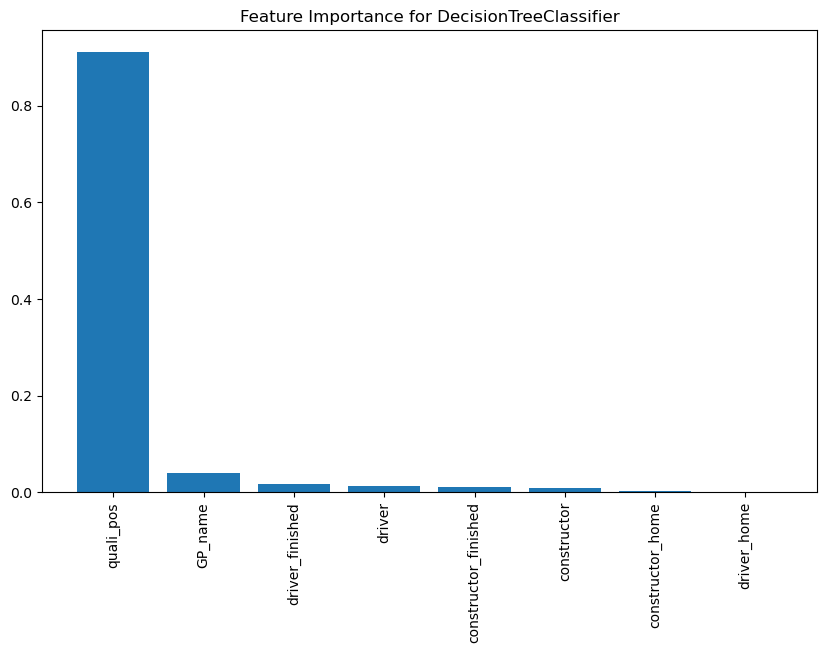

RandomForestClassifier : 0.9552235328382117


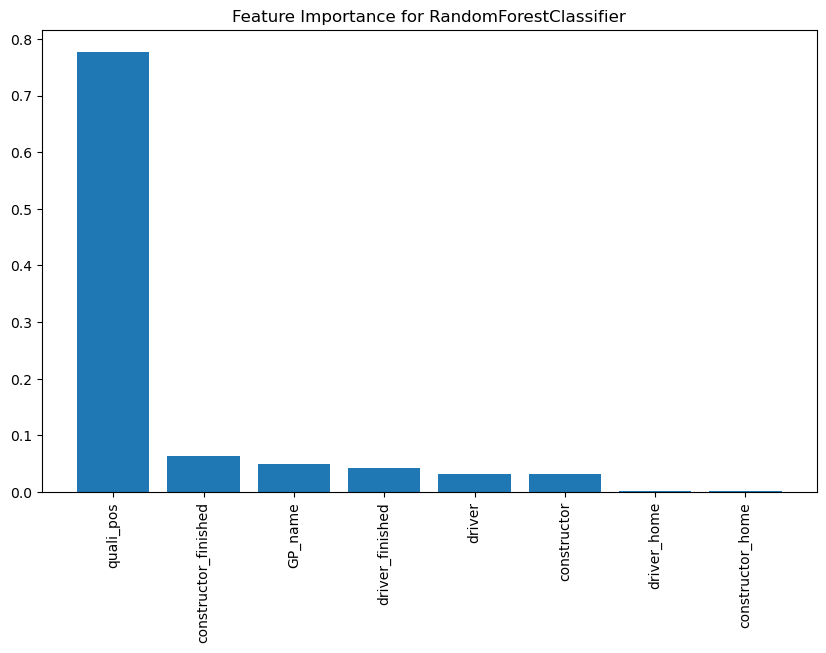

SVC : 0.9360497409973165
GaussianNB : 0.8786287420166843
KNeighborsClassifier : 0.8785300297489025


In [37]:
#cross validation for diffrent models
models = [LogisticRegression(max_iter=10000),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

    # Extract feature importance for models that support it
    if model_dict[model] in ['DecisionTreeClassifier', 'RandomForestClassifier']:
        # Fit the model before extracting feature importance
        model.fit(X_scaled, y)
        feature_importance = model.feature_importances_

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        indices = np.argsort(feature_importance)[::-1]
        plt.bar(range(X_scaled.shape[1]), feature_importance[indices])
        plt.xticks(range(X_scaled.shape[1]), X.columns[indices], rotation=90)
        plt.title(f'Feature Importance for {model_dict[model]}')
        plt.show()

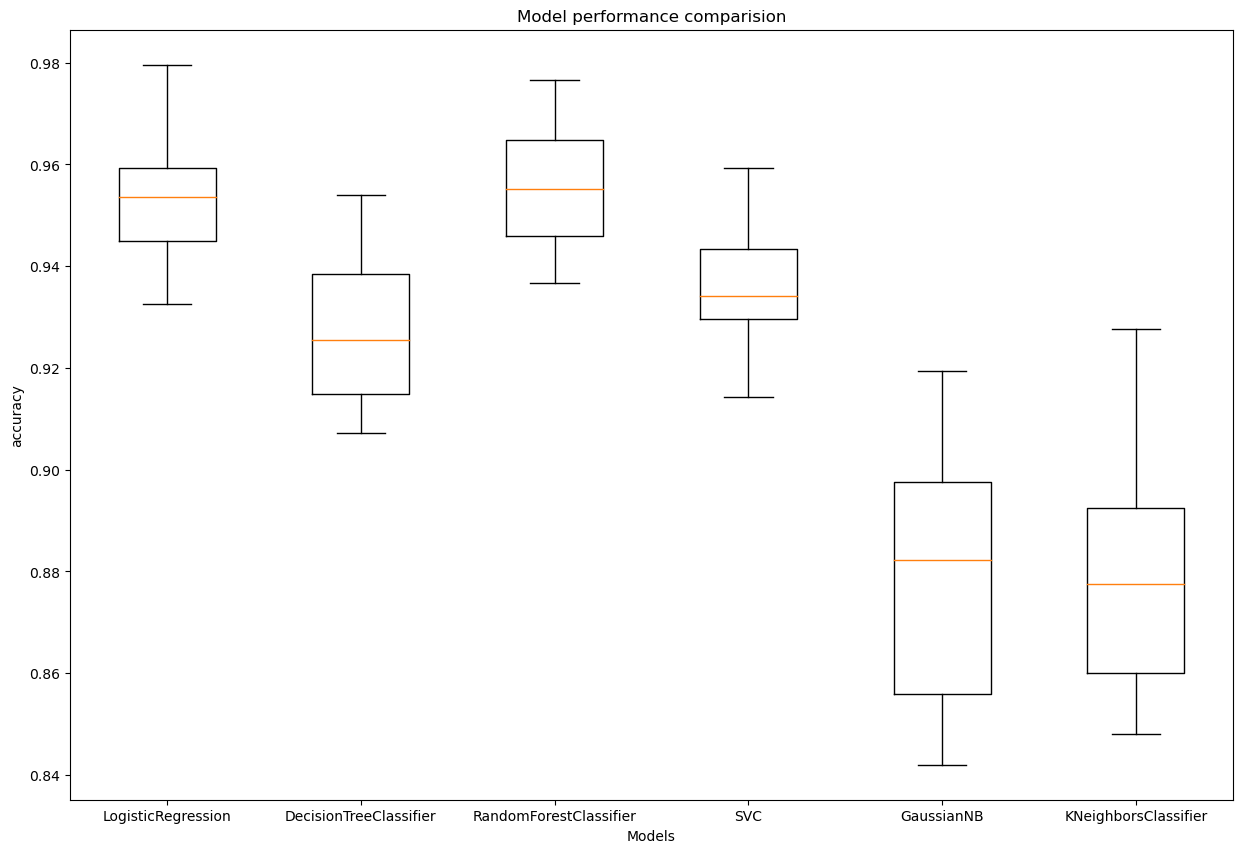

In [38]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

# Logistic Regression from Scratch

In [39]:
cleaned_data

,GP_name,quali_pos,age,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,driver_home,constructor_home
20,Albert Park Grand Prix Circuit,10,27,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,0,0
21,Albert Park Grand Prix Circuit,11,26,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,0,0
22,Albert Park Grand Prix Circuit,3,24,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,0,0
23,Albert Park Grand Prix Circuit,13,23,Alpine,Fernando Alonso,13,0.940510,0.106509,1,1,1981-07-29,0,0
24,Albert Park Grand Prix Circuit,5,22,Alpine,Fernando Alonso,5,0.940510,0.106509,1,1,1981-07-29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,Losail International Circuit,6,32,Mercedes,Valtteri Bottas,3,0.953052,0.046211,1,1,1989-08-28,0,0
9797,Losail International Circuit,11,31,Red Bull,Sergio Pérez,11,0.939516,0.073816,1,1,1990-01-26,0,0
9798,Losail International Circuit,7,24,Red Bull,Max Verstappen,2,0.914286,0.073816,1,1,1997-09-30,0,0
9803,Losail International Circuit,2,25,AlphaTauri,Pierre Gasly,4,0.915966,0.119293,1,1,1996-02-07,0,0


In [40]:
lreg_data = cleaned_data.copy()
lreg_data['position'] = lreg_data['position'].apply(lambda x: group_positions(x))


In [41]:
lreg_data

,GP_name,quali_pos,age,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,driver_home,constructor_home
20,Albert Park Grand Prix Circuit,10,27,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,0,0
21,Albert Park Grand Prix Circuit,11,26,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,0,0
22,Albert Park Grand Prix Circuit,3,24,Alpine,Fernando Alonso,1,0.940510,0.106509,1,1,1981-07-29,0,0
23,Albert Park Grand Prix Circuit,13,23,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,0,0
24,Albert Park Grand Prix Circuit,5,22,Alpine,Fernando Alonso,2,0.940510,0.106509,1,1,1981-07-29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,Losail International Circuit,6,32,Mercedes,Valtteri Bottas,1,0.953052,0.046211,1,1,1989-08-28,0,0
9797,Losail International Circuit,11,31,Red Bull,Sergio Pérez,3,0.939516,0.073816,1,1,1990-01-26,0,0
9798,Losail International Circuit,7,24,Red Bull,Max Verstappen,1,0.914286,0.073816,1,1,1997-09-30,0,0
9803,Losail International Circuit,2,25,AlphaTauri,Pierre Gasly,2,0.915966,0.119293,1,1,1996-02-07,0,0


In [42]:
# dataset for y=1
d1 = lreg_data.copy()
d1['position'] = d1['position'].apply(lambda x: 1 if x==1 else 0)
## dataset for y=2
d2 = lreg_data.copy()
d2['position'] = d2['position'].apply(lambda x: 1 if x==2 else 0)
## dataset for y=3
d3 = lreg_data.copy()
d3['position'] = d3['position'].apply(lambda x: 1 if x==3 else 0)


In [43]:
d2

,GP_name,quali_pos,age,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,driver_home,constructor_home
20,Albert Park Grand Prix Circuit,10,27,Alpine,Fernando Alonso,0,0.940510,0.106509,1,1,1981-07-29,0,0
21,Albert Park Grand Prix Circuit,11,26,Alpine,Fernando Alonso,0,0.940510,0.106509,1,1,1981-07-29,0,0
22,Albert Park Grand Prix Circuit,3,24,Alpine,Fernando Alonso,0,0.940510,0.106509,1,1,1981-07-29,0,0
23,Albert Park Grand Prix Circuit,13,23,Alpine,Fernando Alonso,0,0.940510,0.106509,1,1,1981-07-29,0,0
24,Albert Park Grand Prix Circuit,5,22,Alpine,Fernando Alonso,1,0.940510,0.106509,1,1,1981-07-29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,Losail International Circuit,6,32,Mercedes,Valtteri Bottas,0,0.953052,0.046211,1,1,1989-08-28,0,0
9797,Losail International Circuit,11,31,Red Bull,Sergio Pérez,0,0.939516,0.073816,1,1,1990-01-26,0,0
9798,Losail International Circuit,7,24,Red Bull,Max Verstappen,0,0.914286,0.073816,1,1,1997-09-30,0,0
9803,Losail International Circuit,2,25,AlphaTauri,Pierre Gasly,1,0.915966,0.119293,1,1,1996-02-07,0,0


In [44]:
TrainTest_datadict = {}
datasets = [d1, d2, d3]

for i in range(3):
    X = datasets[i].drop(['position', 'active_driver', 'age','active_constructor', 'dob'], axis=1)
    X = pd.get_dummies(X, columns=['GP_name', 'driver', 'constructor'], drop_first=True)
    X = X.T
    y = datasets[i].position
    y = np.array([y])

    TrainTest_datadict['D' + str(i+1)] = [X, y]

In [45]:
iterations = 10000000 
alpha = 0.2
samples = 5000
cost_values = []
trained_parameters = []

for trainsets in range(3):
    X = TrainTest_datadict['D'+str(trainsets+1)][0] 
    y = TrainTest_datadict['D'+str(trainsets+1)][1]
    #weights: coefficients of the logistic regression model
    weights = np.random.randn(1, X.shape[0])
    #intercept of model
    bias = 0 
    costfunc_values = []
    k = 0
    print('Training for dataset '+str(trainsets +1))
    #training loop
    for i in range(1,iterations+1):
        #logistic function
        #compute weighted sum
        z = np.dot(weights,X) + bias 
        #apply sigmoid function to get hypothesis
        hypothesis = 1/(1 + np.exp(-z)) 

        #cost function
        j = 1/samples*(-1*(np.sum(y*np.log(hypothesis) + (1-y)*np.log(1-hypothesis))))
        costfunc_values.append(j)
        k+=1

        #gradient decent to update the weights and bias
        dw =  1/samples * np.dot(hypothesis-y,X.T)
        db =  1/samples * np.sum(hypothesis-y)
        weights = weights - alpha*dw
        bias = bias - alpha*db

        #stop training conditons: every 2000 iters, print cost. If cost delta is less than threshold for 2 iters, stop
        if i%2000 == 0:
            print('running @ ',j)
        if i%2 == 0:
            if abs(j-costfunc_values[-2])<0.000001:
                if abs(j-costfunc_values[-3])<0.000001:
                    break 
    cost_values.append(costfunc_values)  
    trained_parameters.append([weights,bias])      
    print('iteration number:',k)

Training for dataset 1
running @  0.11548729458684608
running @  0.10928770502610542
running @  0.10652946885553474
running @  0.10498914621365062
iteration number: 8808
Training for dataset 2
running @  0.33306752919647215
running @  0.3262637827186994
iteration number: 5874
Training for dataset 3
running @  0.1393254709716036
running @  0.13372402060572555
running @  0.13152778294555856
iteration number: 7504


In [46]:
for datasetnum in range(3):
    X, y = TrainTest_datadict[f'D{datasetnum + 1}']
    weights, bias = trained_parameters[datasetnum]

    correct_predictions = sum(
        1 for i in range(len(lreg_data))
        if (np.dot(weights, X.T.iloc[i, :]) + bias >= 0.5) == y.T[i, 0]
    )

    accuracy = (correct_predictions / len(lreg_data)) * 100
    print(f'Accuracy for dataset D{datasetnum + 1} = {accuracy:.2f}%')


Accuracy for dataset D1 = 93.66%
Accuracy for dataset D2 = 66.37%
Accuracy for dataset D3 = 91.81%


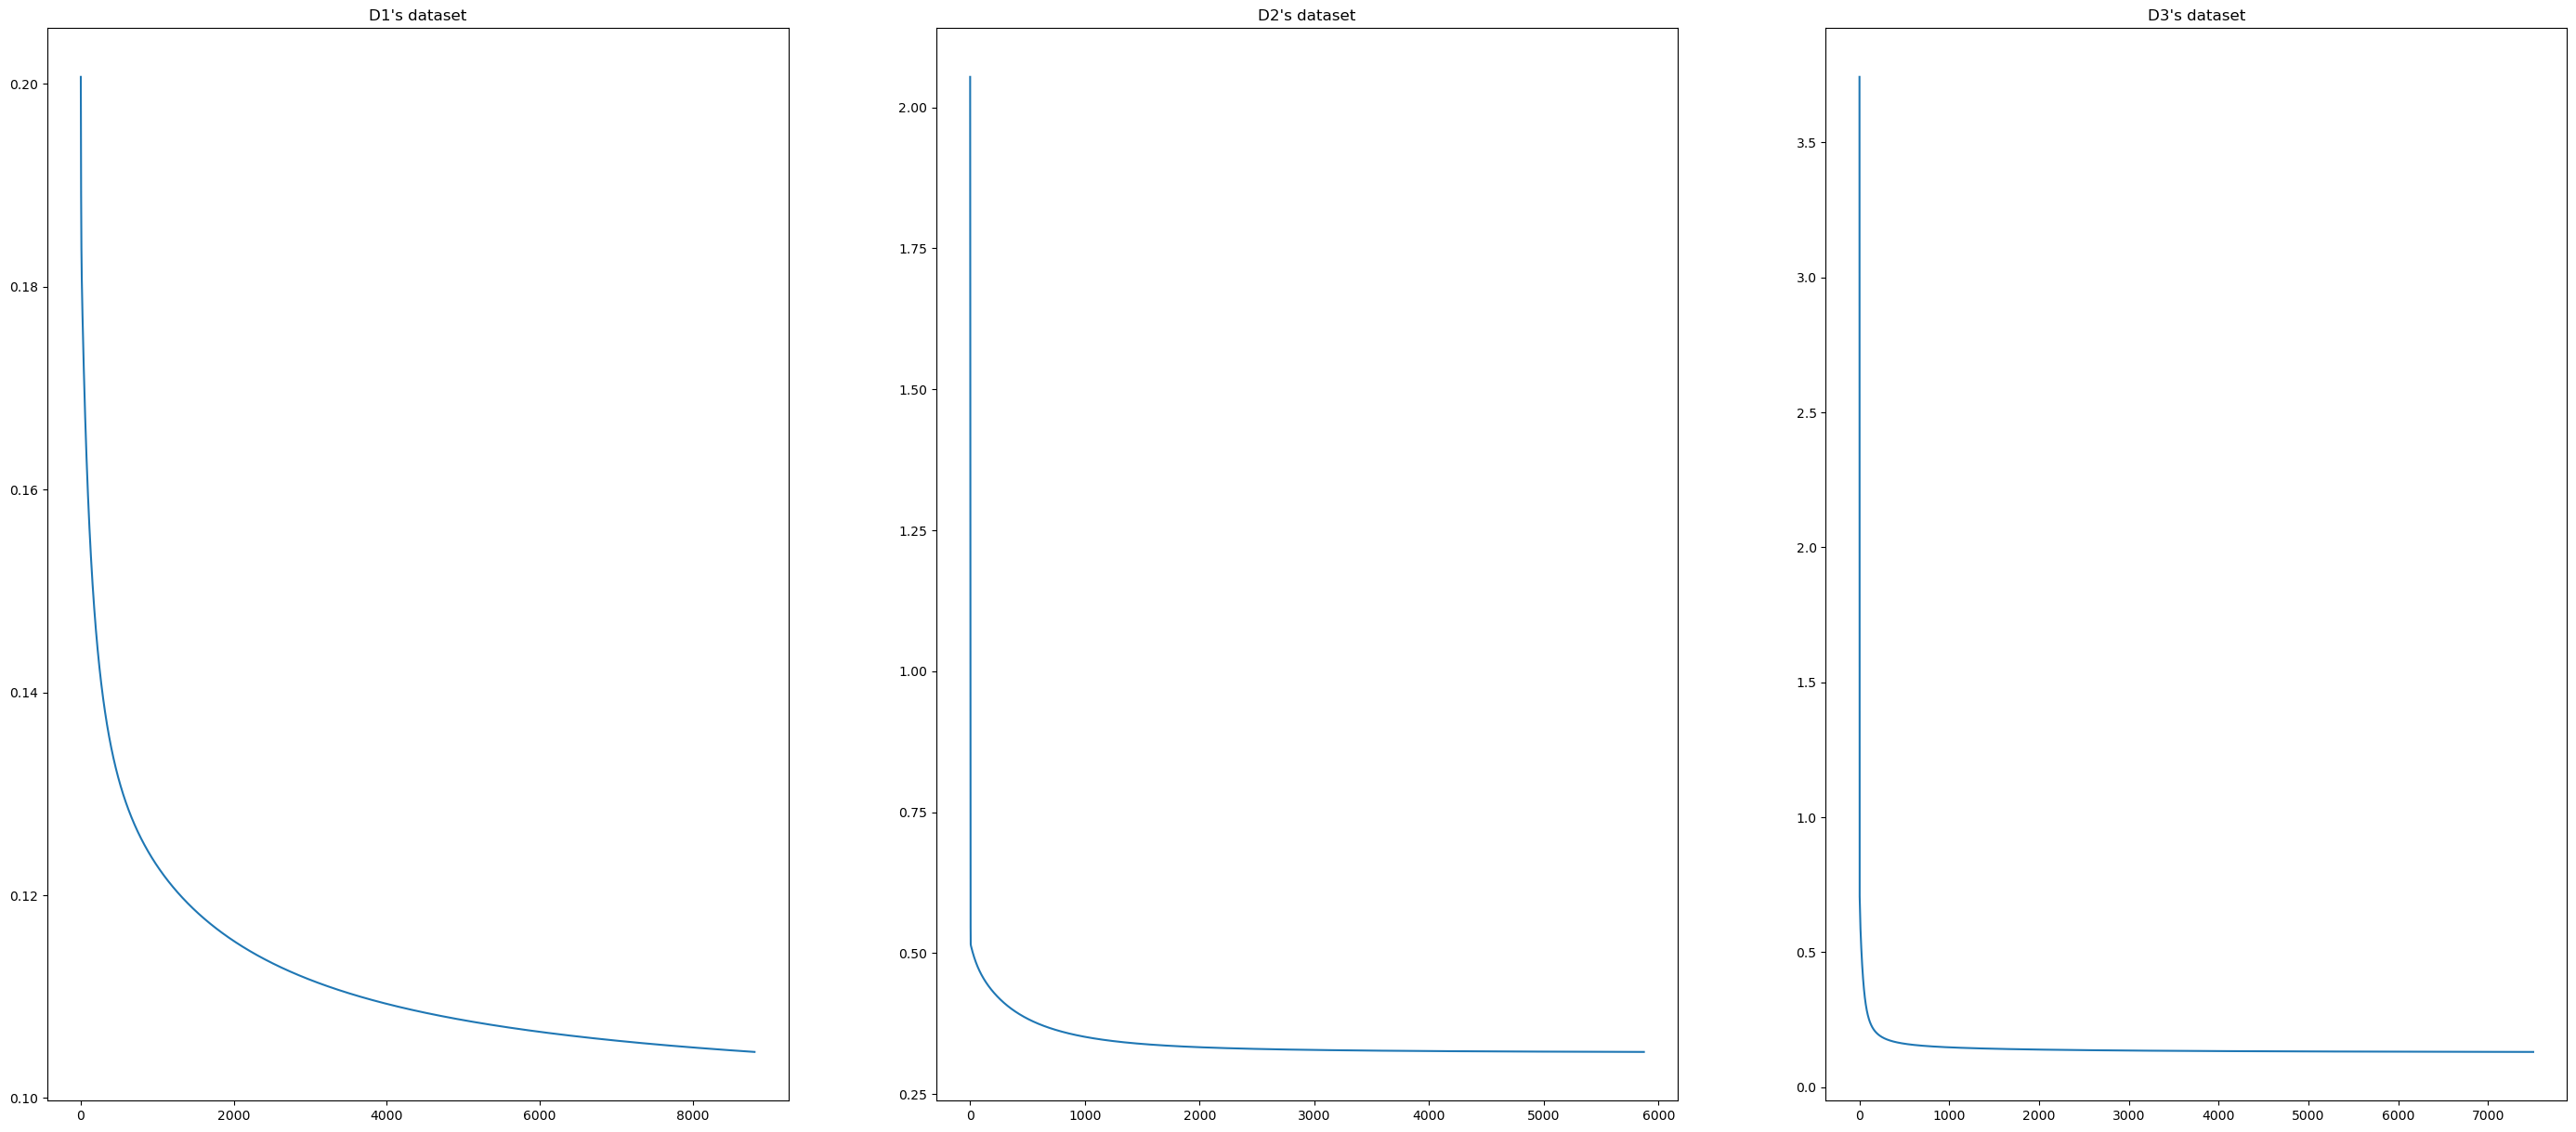

In [47]:
fig, a = plt.subplots(1, 3, figsize=(35, 15))
a[0].plot(cost_values[0])
a[0].set_title("D1's dataset")
a[1].plot(cost_values[1])
a[1].set_title("D2's dataset")
a[2].plot(cost_values[2])  # Corrected index
a[2].set_title("D3's dataset")

plt.show()

# Ranking Problem instead of Classification

In [48]:
ranking_prob

,GP_name,quali_pos,age,constructor,driver,position,driver_finished,constructor_finished,active_driver,active_constructor,dob,raceId,driver_home,constructor_home
20,Albert Park Grand Prix Circuit,10,27,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,1,0,0
21,Albert Park Grand Prix Circuit,11,26,Alpine,Fernando Alonso,12,0.940510,0.106509,1,1,1981-07-29,18,0,0
22,Albert Park Grand Prix Circuit,3,24,Alpine,Fernando Alonso,3,0.940510,0.106509,1,1,1981-07-29,55,0,0
23,Albert Park Grand Prix Circuit,13,23,Alpine,Fernando Alonso,13,0.940510,0.106509,1,1,1981-07-29,71,0,0
24,Albert Park Grand Prix Circuit,5,22,Alpine,Fernando Alonso,5,0.940510,0.106509,1,1,1981-07-29,90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,Losail International Circuit,6,32,Mercedes,Valtteri Bottas,3,0.953052,0.046211,1,1,1989-08-28,1051,0,0
9797,Losail International Circuit,11,31,Red Bull,Sergio Pérez,11,0.939516,0.073816,1,1,1990-01-26,1051,0,0
9798,Losail International Circuit,7,24,Red Bull,Max Verstappen,2,0.914286,0.073816,1,1,1997-09-30,1051,0,0
9803,Losail International Circuit,2,25,AlphaTauri,Pierre Gasly,4,0.915966,0.119293,1,1,1996-02-07,1051,0,0


In [49]:
ranking_prob = pd.get_dummies(ranking_prob, columns=['GP_name', 'driver', 'constructor'], drop_first=True)
ranking_prob = ranking_prob.drop(['dob'], axis=1)


In [50]:
ranking_prob.columns

Index(['quali_pos', 'age', 'position', 'driver_finished',
       'constructor_finished', 'active_driver', 'active_constructor', 'raceId',
       'driver_home', 'constructor_home',
       'GP_name_Autodromo Enzo e Dino Ferrari',
       'GP_name_Autodromo Internazionale del Mugello',
       'GP_name_Autodromo Nazionale di Monza',
       'GP_name_Autódromo Hermanos Rodríguez',
       'GP_name_Autódromo Internacional do Algarve',
       'GP_name_Autódromo José Carlos Pace',
       'GP_name_Bahrain International Circuit', 'GP_name_Baku City Circuit',
       'GP_name_Buddh International Circuit',
       'GP_name_Circuit Gilles Villeneuve', 'GP_name_Circuit Park Zandvoort',
       'GP_name_Circuit Paul Ricard', 'GP_name_Circuit de Barcelona-Catalunya',
       'GP_name_Circuit de Monaco', 'GP_name_Circuit de Nevers Magny-Cours',
       'GP_name_Circuit de Spa-Francorchamps',
       'GP_name_Circuit of the Americas', 'GP_name_Fuji Speedway',
       'GP_name_Hockenheimring', 'GP_name_Hungaroring

In [51]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state=7).split(ranking_prob, groups=ranking_prob['raceId'])

X_train_inds, X_test_inds = next(gss)

# Train Data
train_data = ranking_prob.iloc[X_train_inds]
X_train = train_data.drop('position', axis=1)  # Drop the target variable
y_train = train_data['position']
groups_train = train_data.groupby('raceId').size().to_frame('size')['size'].to_numpy()

# Test Data
test_data = ranking_prob.iloc[X_test_inds]
X_test = test_data.drop('position', axis=1)  # Drop the target variable
y_test = test_data['position']


In [52]:
import xgboost as xgb

model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:ndcg',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.75
)

model.fit(X_train, y_train, group=groups_train, verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=0.05, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [53]:
from scipy.stats import rankdata

def predict(model, df):
    return model.predict(df.drop('position', axis=1))  # Drop the target variable

# Applying predictions on test data grouped by 'raceId'
predictions = (ranking_prob.groupby('raceId')
               .apply(lambda x: rankdata(predict(model, x))))

In [54]:
print(predictions)

raceId
1                                              [1.0, 2.0]
2                                              [1.0, 2.0]
3                                              [1.0, 2.0]
4                                              [2.0, 1.0]
5                                              [1.0, 2.0]
                              ...                        
1106    [8.0, 17.0, 5.0, 6.0, 13.0, 11.0, 4.0, 14.0, 7...
1107    [6.0, 16.0, 4.0, 11.0, 3.0, 2.0, 8.0, 7.0, 12....
1108    [6.0, 12.0, 2.0, 3.0, 5.0, 4.0, 9.0, 10.0, 11....
1109    [13.0, 18.0, 2.0, 3.0, 12.0, 7.0, 11.0, 14.0, ...
1110    [13.0, 17.0, 5.0, 4.0, 3.0, 2.0, 11.0, 12.0, 7...
Length: 394, dtype: object


In [56]:
actual_rankings = (ranking_prob.groupby('raceId')
                   .apply(lambda x: rankdata(x['position'])))

In [58]:

#source: https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d
#https://towardsdatascience.com/comprehensive-guide-to-ranking-evaluation-metrics-7d10382c1025


from scipy.stats import spearmanr, kendalltau

# Convert predictions and actual_rankings to numpy arrays
predictions_array = np.concatenate(predictions.values)
actual_rankings_array = np.concatenate(actual_rankings.values)

# Calculate Spearman's rank correlation coefficient
spearman_corr, _ = spearmanr(predictions_array, actual_rankings_array)
print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")

# Calculate Kendall's Tau
kendall_tau, _ = kendalltau(predictions_array, actual_rankings_array)
print(f"Kendall's Tau: {kendall_tau}")


Spearman's Rank Correlation Coefficient: 0.9375964766505627
Kendall's Tau: 0.8560204594441355


In [59]:
from sklearn.metrics import ndcg_score

# Assuming predictions_array and actual_rankings_array are your arrays
ndcg = ndcg_score([actual_rankings_array], [predictions_array])
print("NDCG:", ndcg)

NDCG: 0.9930445839865994


# Model without quali info

In [61]:
from sklearn.model_selection import train_test_split

sc = StandardScaler()
le = LabelEncoder()

x = cleaned_data.copy()

x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])

# Exclude datetime columns
X = x.drop(['position', 'active_driver', 'active_constructor', 'dob', 'quali_pos'], axis=1)
y = x['position'].apply(lambda x: group_positions(x))

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)


In [62]:
X

,GP_name,age,constructor,driver,driver_finished,constructor_finished,driver_home,constructor_home
20,0,27,2,5,0.940510,0.106509,0,0
21,0,26,2,5,0.940510,0.106509,0,0
22,0,24,2,5,0.940510,0.106509,0,0
23,0,23,2,5,0.940510,0.106509,0,0
24,0,22,2,5,0.940510,0.106509,0,0
...,...,...,...,...,...,...,...,...
9796,25,32,7,19,0.953052,0.046211,0,0
9797,25,31,8,18,0.939516,0.073816,0,0
9798,25,24,8,13,0.914286,0.073816,0,0
9803,25,25,1,17,0.915966,0.119293,0,0


LogisticRegression : 0.5567916666666666
DecisionTreeClassifier : 0.569672619047619


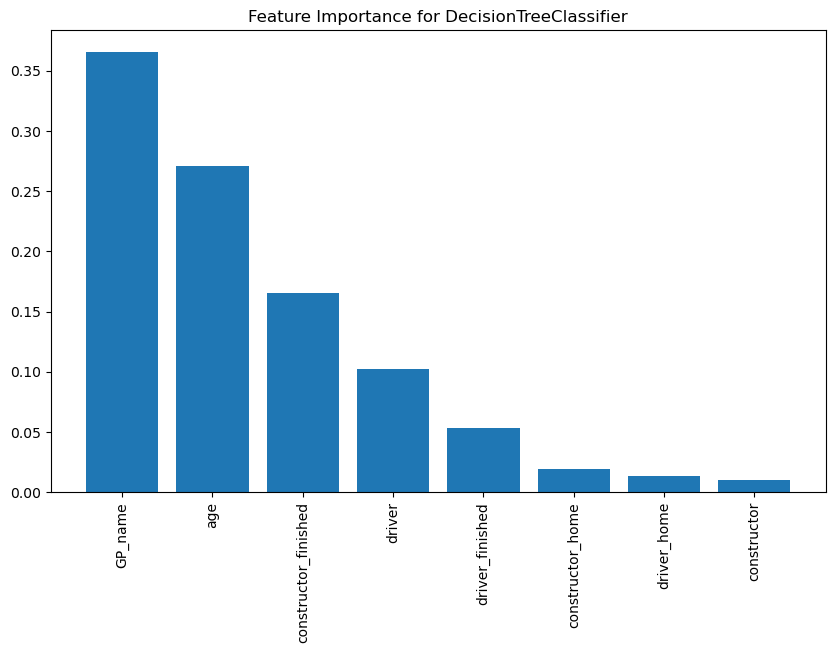

RandomForestClassifier : 0.6307083333333333


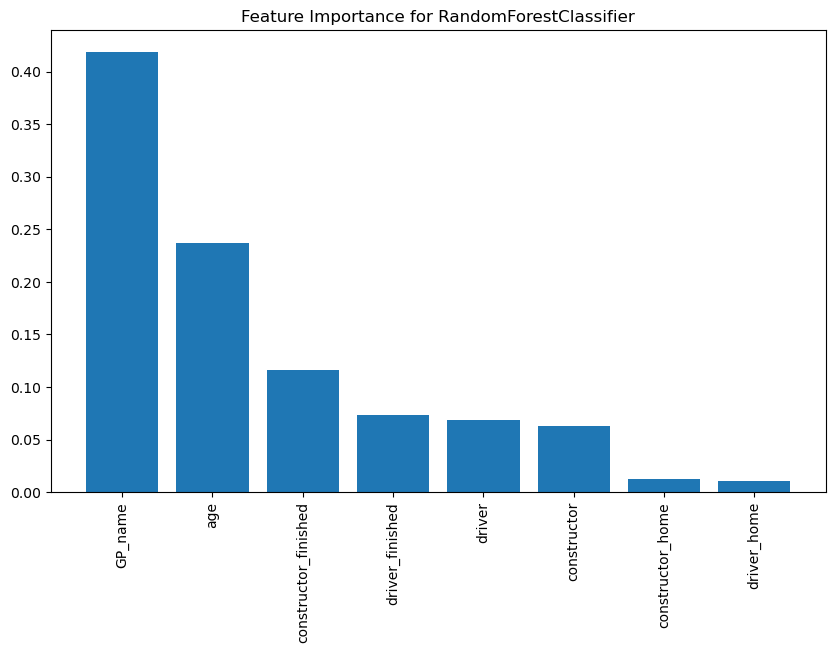

SVC : 0.6164821428571429
GaussianNB : 0.5313670634920635
KNeighborsClassifier : 0.6218194444444445


In [63]:

# Cross-validation for different models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier()
]

names = [
    'LogisticRegression',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'SVC',
    'GaussianNB',
    'KNeighborsClassifier'
]

model_dict = dict(zip(models, names))
mean_results = []
results = []
model_names = []

for model in models:
    cv = StratifiedKFold(n_splits=10)
    result = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    model_names.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

    # Extract feature importance for models that support it
    if model_dict[model] in ['DecisionTreeClassifier', 'RandomForestClassifier']:
        # Fit the model before extracting feature importance
        model.fit(X_train_scaled, y_train)
        feature_importance = model.feature_importances_

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        indices = np.argsort(feature_importance)[::-1]
        plt.bar(range(X_train_scaled.shape[1]), feature_importance[indices])
        plt.xticks(range(X_train_scaled.shape[1]), X_train.columns[indices], rotation=90)
        plt.title(f'Feature Importance for {model_dict[model]}')
        plt.show()

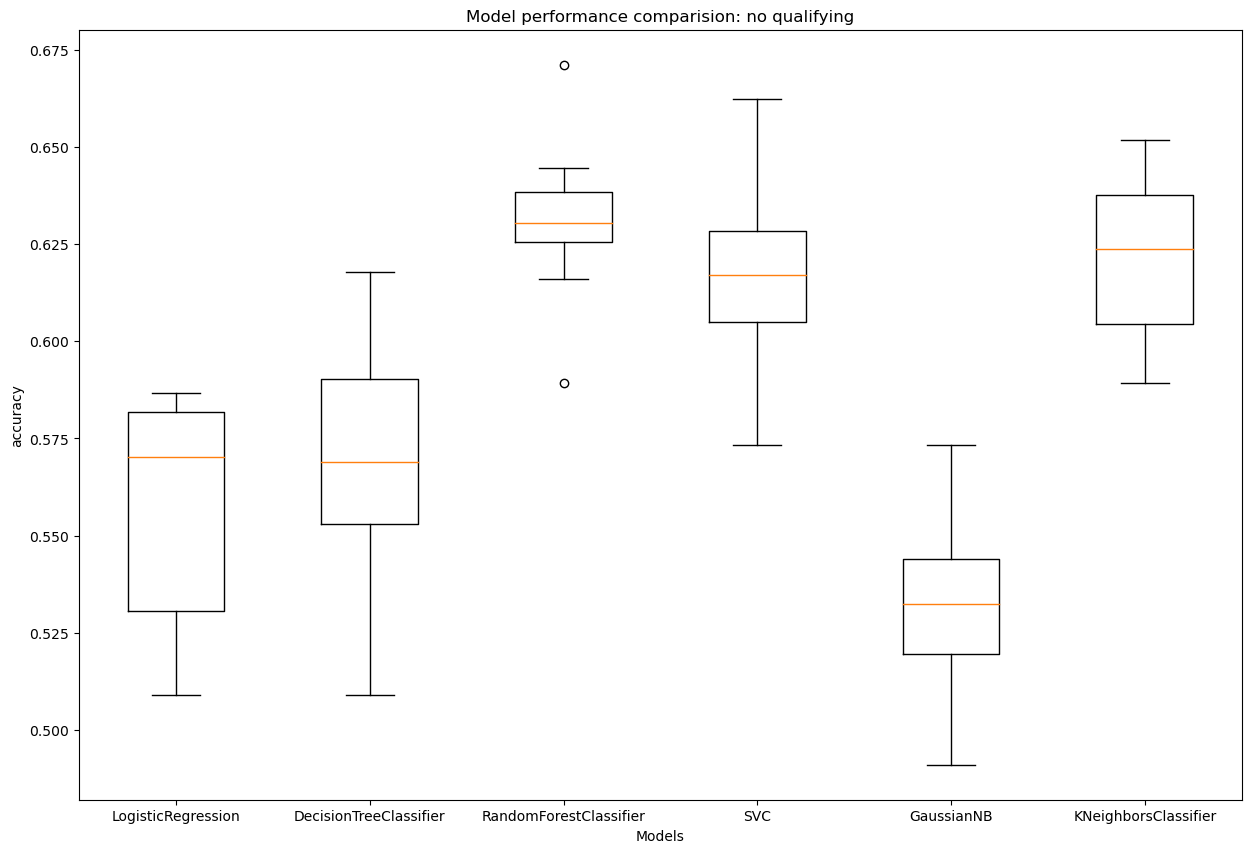

In [64]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision: no qualifying')
plt.show()